<a href="https://colab.research.google.com/github/ArpanGyawali/CNN_models/blob/main/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!sudo pip install mtcnn

     |████████████████████████████████| 2.3 MB 24.5 MB/s 


In [3]:
from os import listdir
from os.path import isdir
from numpy import savez_compressed
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from numpy import asarray, expand_dims
from mtcnn.mtcnn import MTCNN

In [4]:
def detect_face(imageFile, required_size=(160, 160)):
  image = Image.open(imageFile)
  image = image.convert('RGB')
  pixels = asarray(image)
  detector = MTCNN()
  faces =  detector.detect_faces(pixels)
  x1, y1, width, height = faces[0]['box']   #from botttom left
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  face_boundary = pixels[y1:y2, x1:x2]
  face_image = cv2.resize(face_boundary, required_size)
  return face_image

def extract_face(filename, required_size=(160, 160)):
  # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  image = image.convert("RGB")
  # convert to array
  pixels = asarray(image)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  # extract the bounding box from the first face
  x1, y1, width, height = results[0]["box"]
  # bug fix
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  # extract the face
  face = pixels[y1:y2, x1:x2]
  # resize pixels to the model size
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  return face_array

def detect_faces_all(imageFile, required_size=(160, 160)):
  image = Image.open(imageFile)
  image = image.convert('RGB')
  pixels = asarray(image)
  detector = MTCNN()
  face_images = list()
  faces =  detector.detect_faces(pixels)
  for i in range(len(faces)):
    x1, y1, width, height = faces[i]['box']   #from botttom left
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face_boundary = pixels[y1:y2, x1:x2]
    face_image = cv2.resize(face_boundary, required_size)
    face_images.append(face_image)
  return face_images

In [6]:
folder = 'gdrive/MyDrive/datasets'
'''faces = detect_faces_all('gdrive/MyDrive/datasets/5-celebrity-faces-dataset/train/075BCT014/20211013_174804.jpg')
for count, face in enumerate(faces):
  plt.subplot(2,2,count+1)
  plt.imshow(face)'''

"faces = detect_faces_all('gdrive/MyDrive/datasets/5-celebrity-faces-dataset/train/075BCT014/20211013_174804.jpg')\nfor count, face in enumerate(faces):\n  plt.subplot(2,2,count+1)\n  plt.imshow(face)"

80852349_2487315988154205_8057752491502075904_n.jpg
20210411_143424-01.jpeg


KeyboardInterrupt: ignored

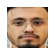

In [46]:
i = 1
for filename in listdir(folder):
  path = folder + filename
  print(filename)
  face = detect_face(path)
  plt.subplot(2,7,i)
  plt.axis('off')
  plt.imshow(face)
  i+=1
plt.show()

In [7]:
def load_faces(directory): #directory like: 5-celebrity-faces-dataset/train/ben afflek/
  faces = list()
  for filename in listdir(directory):
    path = directory + filename
    face = detect_face(path)
    faces.append(face)
  return faces

In [8]:
def load_dataset(directory): #directory like:  5-celebrity-faces-dataset/train/
  X, y = list(), list()
  for subdir in listdir(directory):
    path = directory + subdir + '/'
    if not isdir(path):
      continue
    faces = load_faces(path)
    labels = [subdir for _ in range(len(faces))]
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
    X.extend(faces)
    y.extend(labels)
  return asarray(X), asarray(y)

In [9]:
trainX, trainy = load_dataset(f'{folder}/train/')
print(trainX.shape, trainy.shape)
testX, testy = load_dataset(f'{folder}/val/')
#save arrays to one file in compressed format
savez_compressed(f'{folder}/4catagory_dataset.npz', trainX, trainy, testX, testy)

>loaded 23 examples for class: 075BCT001
>loaded 11 examples for class: 075BCT014
>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
(67, 160, 160, 3) (67,)
>loaded 4 examples for class: 075BCT001
>loaded 2 examples for class: 075BCT014


In [10]:
from numpy import load
from keras.models import load_model

In [11]:
def get_embedding(model, face_pixels):
  face_pixels = face_pixels.astype('float32')
  mean, std = face_pixels.mean(), face_pixels.std()
  face_pixels = (face_pixels - mean) / std
  samples = expand_dims(face_pixels, axis=0)
  yhat = model.predict(samples)   #predict the embedd

  return yhat[0]

In [14]:
data = load(f'{folder}/4catagory_dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (67, 160, 160, 3) (67,) (6, 160, 160, 3) (6,)


In [15]:
model = load_model('gdrive/MyDrive/models/facenet_keras.h5')
print('Model Loaded')

Model Loaded


In [17]:
newTrainX = list()
for face_pixels in trainX:
  embedding = get_embedding(model, face_pixels)
  newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
  embedding = get_embedding(model, face_pixels)
  newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

savez_compressed(f'{folder}/4catagory_embedding.npz', newTrainX, trainy, newTestX, testy)

(67, 128)
(6, 128)


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.svm import SVC

In [19]:
embedding_data = load(f'{folder}/4catagory_embedding.npz')
trainX, trainy, testX, testy = embedding_data['arr_0'], embedding_data['arr_1'], embedding_data['arr_2'], embedding_data['arr_3']


In [20]:
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

Dataset: train=67, test=6


In [21]:
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [22]:
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

In [23]:
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

In [24]:
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)

In [25]:
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))


Accuracy: train=98.507, test=100.000


In [26]:
from random import choice
from numpy import reshape

Predicted: 075BCT001 (90.521)
Expected: 075BCT001


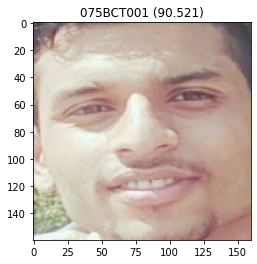

In [28]:
data = load(f'{folder}/4catagory_dataset.npz')
testX_faces = data['arr_2']

data = load(f'{folder}/4catagory_embedding.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

Loaded Model
Predicted: 075BCT014 (100.000)


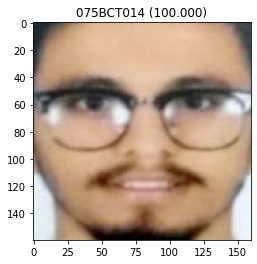

In [30]:
face_pixels = detect_face('gdrive/MyDrive/datasets/5-celebrity-faces-dataset/test/CamScanner 02-21-2021 07.21_1.jpg')
fn_model = load_model('gdrive/MyDrive/models/facenet_keras.h5')
print("Loaded Model")
face_embedded = get_embedding(fn_model, face_pixels)
# prediction for the face
samples = expand_dims(face_embedded, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
# plot for fun
plt.imshow(face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()